In [1]:
import networkx as nx
import pandas as pd
from tqdm import tqdm_notebook,tqdm
import numpy as np
import parmap
parent_path='../Data/New_Data_15-06-2020/'

In [2]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data_final.pkl')
whatsapp_data=pd.read_csv(parent_path+'Data_text_spam_removed_v02_hi_en.csv')
temp=whatsapp_data[['group_id_anonymized','phone_num_anonymized','message_text','timestamp']]
duplicateDFRow = temp[temp.duplicated()]
whatsapp_data=whatsapp_data.drop(list(duplicateDFRow.index))


In [3]:
whatsapp_data=whatsapp_data.sort_values('timestamp')

In [18]:
df_user_matched=pd.read_csv(parent_path+'final_user_selection_matched.csv')

In [19]:
len(df_user_matched[df_user_matched['annotation']=='Non fear speech'])

2932

In [4]:
dict_users_ids={}
dict_users_names={}
dict_users_groups={}  
count=0
for user in tqdm(whatsapp_data['phone_num_anonymized'].unique()):
    dict_users_ids[count]=user
#         dict_users_names[count]='fear speech'
#     else:
#         dict_users_ids[count]=user
#         dict_users_names[count]='normal'
        
    dict_users_groups[count]=set(whatsapp_data[whatsapp_data['phone_num_anonymized']==user].group_id_anonymized)
    count+=1

100%|██████████| 109542/109542 [02:02<00:00, 897.69it/s]


In [ ]:
dict_users_groups[247483]

In [ ]:
count_empty=0

for key in range(count):
    if dict_users_groups[key]:
         pass
    else:
        count_empty+=1

    

In [ ]:
count_empty

In [ ]:
def add_edge_tuples(list_users,user1):
    tuples_user_info=[]
    for user2 in list_users:
        if(user1==user2):
            continue
        temp_user1_groups= dict_users_groups[user1]
        temp_user2_groups= dict_users_groups[user2]
        common_groups=len(temp_user1_groups.intersection(temp_user2_groups))
        if(common_groups>0):
            tuples_user_info.append([user1,user2,common_groups])
    return tuples_user_info



In [6]:
tuples_user_info=[]
#list_split = np.array_split(list(dict_users_ids.keys()), n_process)

list_users= list(dict_users_ids.keys())
for i in tqdm(range(len(list_users))):
#     list_all = parmap.map(add_edge_tuples, list_split, user1, pm_processes=n_process,pm_pbar=False)
#     flat_list = [item for sublist in list_all for item in sublist]
#     tuples_user_info+=flat_list
    for j in range(i,len(list_users)):
        if(i==j):
            continue
        temp_user1_groups= dict_users_groups[list_users[i]]
        temp_user2_groups= dict_users_groups[list_users[j]]
        common_groups=len(temp_user1_groups.intersection(temp_user2_groups))
        if(common_groups>0):
            tuples_user_info.append([list_users[i],list_users[j],common_groups])

100%|██████████| 109542/109542 [43:19<00:00, 42.14it/s]  


In [7]:
import networkx as nx

In [8]:
G = nx.Graph()

In [12]:
print(nx.is_connected(G))

False


In [15]:
len(G.edges())

6382883

In [14]:
G.add_weighted_edges_from(tuples_user_info)

In [ ]:
import json

def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError

#json.dumps({'value': numpy.int64(42)}, default=convert)


with open("Networks/user_dict.json", 'w') as fp:
    json.dump(dict_users_ids, fp,ensure_ascii=False,default=convert)
with open("Networks/user_labels_dict.json", 'w') as fp:
    json.dump(dict_users_names, fp,ensure_ascii=False,default=convert)
nx.write_weighted_edgelist(G, "Networks/users_network.edgelist.gz")

### Load precomputed

In [ ]:
import json

with open("Networks/user_dict.json", 'r') as fp:
    dict_users_ids=json.load(fp)
with open("Networks/user_labels_dict.json", 'r') as fp:
    dict_users_names=json.load(fp)

    
G=nx.read_weighted_edgelist("Networks/users_network.edgelist.gz")
    

In [16]:
k_cores=nx.algorithms.core.core_number(G)

In [17]:
len(k_cores)

109292

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)

In [ ]:
S = G.subgraph(largest_cc).copy()

In [ ]:
dict_centrality=nx.algorithms.centrality.information_centrality(S, weight='weight', dtype='int', solver='full')

In [21]:
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


100%|██████████| 4782/4782 [00:00<00:00, 14797.42it/s]


In [22]:
len(data_fear_speech.phone_num_anonymized.unique())

2933

In [28]:
list_messages=[]
for user in data_fear_speech.phone_num_anonymized.unique():
    temp_user=data_fear_speech[data_fear_speech['phone_num_anonymized']==user]
    list_messages.append(len(temp_user))
    



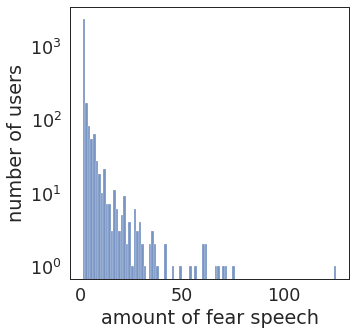

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=2.0)

font = {
    'weight' : 'normal',
    'size'   : 11}
ax = sns.histplot(x=list_messages,bins=100)

plt.xlabel('amount of fear speech')
plt.ylabel('number of users')

plt.yscale('log')
plt.savefig('../Fear_speech_results/fear_speech_per_users.pdf',bbox_inches='tight',dpi=400)

plt.show()

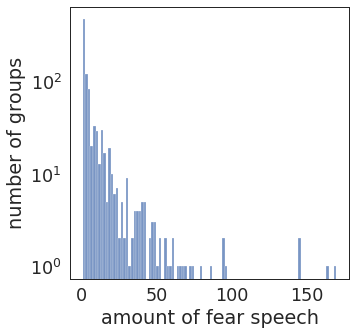

In [30]:


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=2.0)

font = {
    'weight' : 'normal',
    'size'   : 11}


list_messages=[]
for user in data_fear_speech.group_id_anonymized.unique():
    temp_user=data_fear_speech[data_fear_speech['group_id_anonymized']==user]
    list_messages.append(len(temp_user))
    
ax = sns.histplot(x=list_messages,bins=100)

plt.xlabel('amount of fear speech')
plt.ylabel('number of groups')

plt.yscale('log')
plt.savefig('../Fear_speech_results/fear_speech_per_groups.pdf',bbox_inches='tight',dpi=400)

plt.show()

In [31]:
dict_users_ids_reverse = {v: k for k, v in dict_users_ids.items()}


In [32]:
len()

TypeError: len() takes exactly one argument (0 given)

In [43]:
list_cores_fs=[]
count=0
for user in data_fear_speech.phone_num_anonymized.unique():
   
    try:
        list_cores_fs.append(k_cores[dict_users_ids_reverse[user]])
    except:
        count+=1
        
count

1

In [76]:
data_fear_speech

,group_id_anonymized,phone_num_anonymized,message_text,timestamp,media_type,media_url,forwarded,orig_index,language,only_urls,is_spam
677,9356,235075,राजस्थान मे किसी मुस्लिम की भीड़ ने हत्या इसलि...,1532311954000,None,None,64,5716783,hi,0,0
1062,9699,244246,आजादी के बाद से एक समस्या शुरू से मुँह फाड़े ख...,1532338582000,None,None,65,6087694,hi,0,0
1371,9087,54645,आजादी के बाद से एक समस्या शुरू से मुँह फाड़े ख...,1532356425000,None,None,65,5562669,hi,0,0
1854,9356,235075,"##मॉब_लॉंचिंग ""मॉब लिंचिंग पर राजनीति गर्म है....",1532406075000,None,None,64,5716588,hi,0,0
2255,9356,217436,"*🚩🏹प्रशाषक समिति🏹🚩* *##मॉब_लॉंचिंग* 🐷😈🐖🐖 *""मॉ...",1532436871000,None,None,65,5717803,hi,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1422960,6687,173142,*जय हिंद✊🚩* (१४/ पोस्ट:-३) *🇮🇳🇮🇳15 अगस्त पर🇮🇳...,1565760314000,None,None,1,4095862,hi,0,0
1422980,4033,122354,*जय हिंद✊🚩* (१४/ पोस्ट:-३) *🇮🇳🇮🇳15 अगस्त पर🇮🇳...,1565761162000,None,None,1,2941633,hi,0,0
1423171,37,21902,मुस्लीम ने मोदी से कहा 10/15 मिनट के ल...,1565765294000,None,None,1,338378,hi,0,0
1423184,3989,102886,*जय हिंद✊🚩* (१४/ पोस्ट:-३) *🇮🇳🇮🇳15 अगस्त पर🇮🇳...,1565765772000,None,None,1,2942257,hi,0,0


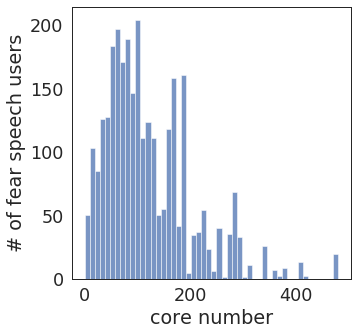

In [44]:
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=2.0)

font = {
    'weight' : 'normal',
    'size'   : 11}
ax = sns.histplot(x=list_cores,bins=50)

plt.xlabel('core number')
plt.ylabel('# of fear speech users')
#ax.set(ylim=(0, 1000))
#plt.yscale('log')
plt.savefig('../Fear_speech_results/kcore_fear_speech_users.pdf',bbox_inches='tight',dpi=400)

plt.show()

In [75]:
list_cores_fs
len([x for x in list_cores_nfs if x>=100])/len(list_cores_nfs)

0.4367066895368782

In [69]:
len(list_cores_fs)

2932

In [35]:
user_nfs=df_user_matched[df_user_matched['annotation']=='Non fear speech'].user_id

In [36]:
len(user_nfs)

2932

In [45]:
list_cores_nfs=[]
for user in user_nfs:
    try:
        list_cores_nfs.append(k_cores[dict_users_ids_reverse[int(user)]])
    except:
        list_cores.append(0)

In [50]:
sns.color_palette()[1]

(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)

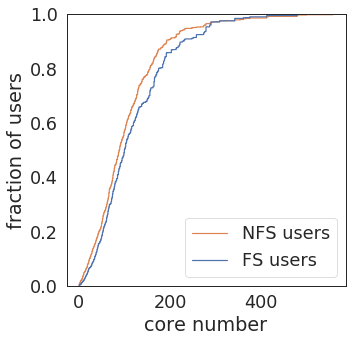

In [66]:
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=2.0)

font = {
    'weight' : 'normal',
    'size'   : 11}
#ax = sns.histplot(x=list_cores_nfs,bins=50,color='#DE8F05')
ax=sns.ecdfplot(x=list_cores_nfs,color=sns.color_palette()[1])
ax=sns.ecdfplot(x=list_cores_fs,color=sns.color_palette()[0])

plt.xlabel('core number')
plt.ylabel('fraction of users')
#ax.set(ylim=(0, 1000))
plt.legend(['NFS users','FS users'])
#plt.yscale('log')
plt.savefig('../Fear_speech_results/kcore_non_users.pdf',bbox_inches='tight',dpi=400)

plt.show()

In [59]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

seed(1)
stat, p = mannwhitneyu(list_cores_fs, list_cores_nfs)

In [63]:
print('Statistics=%.3f, p=%.6f' % (stat, p))

Statistics=3793358.500, p=0.000000


In [83]:
admin_data=pd.read_csv(parent_path+'group_membership.csv',sep='\t')
admin_data=admin_data[admin_data['is_admin']!=0]

In [84]:
admin_data

,group_id,user_id,is_admin
2,56,5150,1
14,56,519,1
15,56,3141,2
22,56,2329,1
32,56,9277,1
...,...,...,...
267484,9976,233159,1
267485,9976,249609,1
267486,9976,249610,1
267487,9977,249611,1


In [ ]:
num_spreader=[]
for index,row in tqdm(data_fear_speech.phone_num_anonymized.unique(),total=len(df_user_matched)):
    try:
        temp=admin_data[admin_data['user_id']==row['user_id']].group_id.unique()
        
        
    except KeyError:
        temp=0
    num_spreader.append([row['user_id'],temp,row['annotation']])
    

In [85]:
data_fear_speech

,group_id_anonymized,phone_num_anonymized,message_text,timestamp,media_type,media_url,forwarded,orig_index,language,only_urls,is_spam
677,9356,235075,राजस्थान मे किसी मुस्लिम की भीड़ ने हत्या इसलि...,1532311954000,None,None,64,5716783,hi,0,0
1062,9699,244246,आजादी के बाद से एक समस्या शुरू से मुँह फाड़े ख...,1532338582000,None,None,65,6087694,hi,0,0
1371,9087,54645,आजादी के बाद से एक समस्या शुरू से मुँह फाड़े ख...,1532356425000,None,None,65,5562669,hi,0,0
1854,9356,235075,"##मॉब_लॉंचिंग ""मॉब लिंचिंग पर राजनीति गर्म है....",1532406075000,None,None,64,5716588,hi,0,0
2255,9356,217436,"*🚩🏹प्रशाषक समिति🏹🚩* *##मॉब_लॉंचिंग* 🐷😈🐖🐖 *""मॉ...",1532436871000,None,None,65,5717803,hi,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1422960,6687,173142,*जय हिंद✊🚩* (१४/ पोस्ट:-३) *🇮🇳🇮🇳15 अगस्त पर🇮🇳...,1565760314000,None,None,1,4095862,hi,0,0
1422980,4033,122354,*जय हिंद✊🚩* (१४/ पोस्ट:-३) *🇮🇳🇮🇳15 अगस्त पर🇮🇳...,1565761162000,None,None,1,2941633,hi,0,0
1423171,37,21902,मुस्लीम ने मोदी से कहा 10/15 मिनट के ल...,1565765294000,None,None,1,338378,hi,0,0
1423184,3989,102886,*जय हिंद✊🚩* (१४/ पोस्ट:-३) *🇮🇳🇮🇳15 अगस्त पर🇮🇳...,1565765772000,None,None,1,2942257,hi,0,0


In [88]:
temp_users=[]
for user in data_fear_speech.phone_num_anonymized.unique():
    try:
        temp=set(admin_data[admin_data['user_id']==user].group_id.unique())
        temp_2=set(data_fear_speech[data_fear_speech['phone_num_anonymized']==user].group_id_anonymized.unique())
        
        num_groups=len(temp.intersection(temp_2))
        if(num_groups>0):
            temp_users.append(num_groups)
        
    except KeyError:
        pass
        

In [92]:
len(temp_users)/data_fear_speech.phone_num_anonymized.nunique()

0.08660075008523696

In [ ]:
num_spreader=[]
for index,row in tqdm(data_fear_speech.phone_num_anonymized.unique(),total=len(df_user_matched)):
    try:
        temp=admin_data[admin_data['user_id']==row['user_id']].group_id.unique()
        
        
    except KeyError:
        temp=0
    num_spreader.append([row['user_id'],temp,row['annotation']])
    

In [ ]:
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}


df_num_users=pd.DataFrame(num_spreader,columns=['user_id','number of groups','label'])
ax1 = sns.barplot(x="label", y="number of groups", data=df_num_users)
plt.savefig('../Fear_speech_results/admins_in_fear_speech_users.pdf',bbox_inches='tight',dpi=400)
plt.show()


In [ ]:
len(df_num_users[(df_num_users['label']=='Fear speech') & (df_num_users['number of groups']>0)])/len(df_num_users[(df_num_users['label']=='Fear speech')])

In [ ]:
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


In [ ]:
temp=data_fear_speech.sample(1)
whatsapp_data[(whatsapp_data['group_id_anonymized']==temp.iloc[0]['group_id_anonymized']) & (whatsapp_data['timestamp'].between(temp.iloc[0]['timestamp'],temp.iloc[0]['timestamp']+(2*24*60*60*1000) , inclusive=True))]

In [ ]:
user_actions=pd.read_csv(parent_path+'user_actions.csv',sep='\t')
user_actions=user_actions.sort_values('timestamp')

In [ ]:
user_actions.head()

In [ ]:
count_no_left=0
time_to_leave=[]
for index,row in tqdm_notebook(data_fear_speech.iterrows(),total=len(data_fear_speech)):
    temp_action=user_actions[(user_actions['timestamp']>int(row['timestamp']/1000))&(user_actions['group_id']==row['group_id_anonymized'])&(user_actions['user_id']==row['phone_num_anonymized'])]
    flag=0
    if(len(temp_action)==0):
        count_no_left+=1
        continue
    for index1,row1 in temp_action.iterrows():
        if(row1['action'] in ['removed']):
            time_shift=(row1['timestamp']-int(row['timestamp']/1000))/(24*60*60)
            time_to_leave.append(time_shift)
            flag=1
            break
    if(flag==0):
        count_no_left+=1
        
           
    
        
        

In [ ]:
len(time_to_leave)/len(data_fear_speech)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(time_to_leave, bins = 100)
plt.xlabel('days when removed from the group')
plt.ylabel('number of cases')
plt.show()

In [ ]:
user_actions.action.unique()

### Groups